# Approches agglomératives et bayésiennes

Pierrick DOSSIN  
Guillaume RIU

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

Charger les Données

In [2]:
# votes
votes = pd.read_csv('Data/votes.csv')

# items
items = pd.read_csv('Data/items.csv')

# users
users = pd.read_csv('Data/u.csv')

## Matrice Utilisateur Item
MUI = votes.pivot(index="user.id", columns="item.id", values="rating")
MUI.head()

item.id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user.id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
## Convertir le DF en une matrice numpy
MUI_numpy      = MUI.to_numpy()
MUI_numpy_flat = MUI_numpy.reshape(-1)

# Matrice utilisateur item avec des 0 à la place de NaN
MUI_zero = MUI.replace(np.nan, 0)

### Définition des métriques

In [4]:
# Mean Squared Error
def MSE_mat(y_pred, y_true):
    return np.nanmean((y_pred - y_true)**2)

# Erreur absolue moyenne
def MAE_mat(y_pred, y_true):
    return np.nanmean(np.abs(y_pred - y_true))

In [5]:
## Création des indices pour les valeurs différentes de np.nan
MUI_numpy_flat = MUI_numpy.reshape(-1)
indices    = np.arange(0, MUI_numpy.shape[0]*MUI_numpy.shape[1])
indices_na = indices[~np.isnan(MUI_numpy_flat)]

## Split Train Test des indices
nbre_replis = 5
np.random.shuffle(indices_na)
idx_split = np.split(indices_na, nbre_replis)

### Approche SVD

C:\Users\pierr\AppData\Local\Temp\ipykernel_6032\1313428937.py:21: RuntimeWarning: Mean of empty slice
  moyenne_I_repeat = np.repeat(np.nanmean(MUI_numpy_train, axis=0, keepdims=True), MUI_numpy_train.shape[0], axis=0)


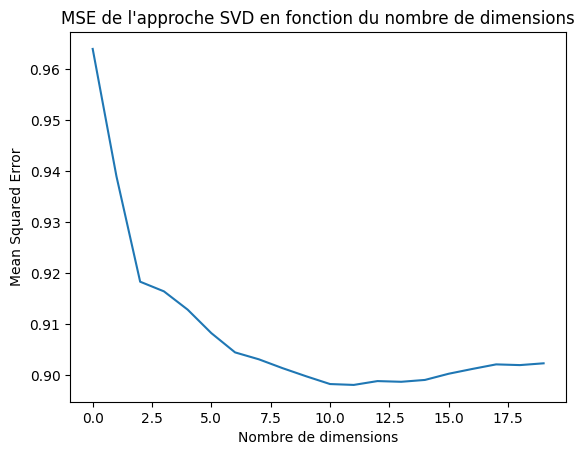


La plus faible erreur MSE est 0.898074380258944 atteinte pour 11 dimensions.
L'erreur MAE pour 11 dimensions est 0.756581153312571.


In [7]:
maxDim = 20
MSE = np.zeros((maxDim, nbre_replis))
MAE = np.zeros((maxDim, nbre_replis))

for i in range(nbre_replis):
    ## Pour chacun des cinq plis, je construis ma liste d'indice train et test
    idx_train = np.delete(idx_split, i, axis=0).flatten()
    idx_test  = idx_split[i]

    ## J'enlève les valeurs de test de la matrice d'entrainement, et vice versa
    MUI_numpy_flat_train = MUI_numpy_flat.copy()
    MUI_numpy_flat_test  = MUI_numpy_flat.copy()
    MUI_numpy_flat_train[idx_test] = np.nan
    MUI_numpy_flat_test[idx_train] = np.nan

    #  Je redonne la structure de matrice aux ensembles de test et d'entrainement
    MUI_numpy_train = MUI_numpy_flat_train.reshape(MUI_numpy.shape)
    MUI_numpy_test  = MUI_numpy_flat_test.reshape(MUI_numpy.shape)

    moyenne_U_repeat = np.repeat(np.nanmean(MUI_numpy_train, axis=1, keepdims=True), MUI_numpy_train.shape[1], axis=1)
    moyenne_I_repeat = np.repeat(np.nanmean(MUI_numpy_train, axis=0, keepdims=True), MUI_numpy_train.shape[0], axis=0)
    MUI_numpy_train_mean = np.nanmean([moyenne_U_repeat, moyenne_I_repeat], axis=0)
    
    MUI_factorizable = np.nan_to_num(MUI_numpy_train - MUI_numpy_train_mean)
    u, s, v = np.linalg.svd(MUI_factorizable, full_matrices=False)

    for nDim in range(maxDim):
        s2 = s.copy()
        s2[nDim:] = 0
        
        MUI_pred = u @ np.diag(s2) @ v + MUI_numpy_train_mean
        MSE[nDim, i] = MSE_mat(MUI_pred, MUI_numpy_test)
        MAE[nDim, i] = MAE_mat(MUI_pred, MUI_numpy_test)

MSE = np.mean(MSE, axis=1)
MAE = np.mean(MAE, axis=1)

plt.plot(range(maxDim), MSE)

plt.xlabel('Nombre de dimensions')
plt.ylabel('Mean Squared Error')
plt.title('MSE de l\'approche SVD en fonction du nombre de dimensions')

plt.show()

print(f"\nLa plus faible erreur MSE est {min(MSE)} atteinte pour {np.argmin(MSE)} dimensions.")
print(f"L'erreur MAE pour {np.argmin(MSE)} dimensions est {MAE[np.argmin(MSE)]}.")

### Approche K-Means

C:\Users\pierr\AppData\Local\Temp\ipykernel_6032\629639480.py:32: RuntimeWarning: Mean of empty slice
  moyenne_I_repeat = np.repeat(np.nanmean(MUI_numpy_train, axis=0, keepdims=True), MUI_numpy_train.shape[0], axis=0)


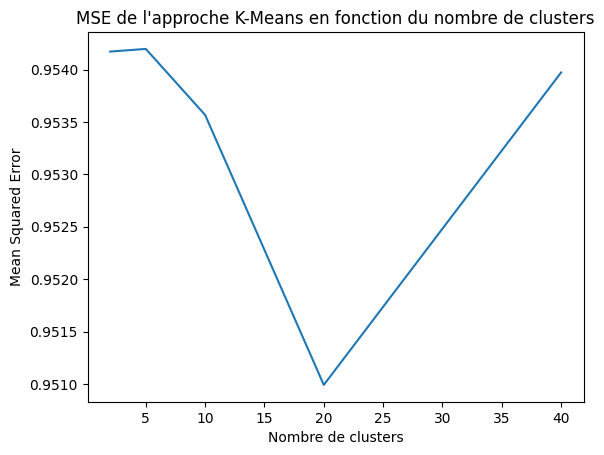


La plus faible erreur MSE est 0.9509907173341265 atteinte pour 20 clusters.
L'erreur MAE pour 20 clusters est 0.7848896091263242.


In [10]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric, type_metric

# Définition de la corrélation 
def corr(a, b):
    return np.cov(a, b)[0,1] / (np.std(a)*np.std(b))

# define a custom metric
metric = distance_metric(type_metric.USER_DEFINED, func=corr)


MSE = np.zeros((5, 5))
MAE = np.zeros((5, 5))
nClusters = [2, 5, 10, 20, 40]

for i in range(nbre_replis):
    ## Pour chacun des cinq plis, je construis ma liste d'indice train et test
    idx_train = np.delete(idx_split, i, axis=0).flatten()
    idx_test  = idx_split[i]

    ## J'enlève les valeurs de test de la matrice d'entrainement, et vice versa
    MUI_numpy_flat_train = MUI_numpy_flat.copy()
    MUI_numpy_flat_test  = MUI_numpy_flat.copy()
    MUI_numpy_flat_train[idx_test] = np.nan
    MUI_numpy_flat_test[idx_train] = np.nan

    #  Je redonne la structure de matrice aux ensembles de test et d'entrainement
    MUI_numpy_train = MUI_numpy_flat_train.reshape(MUI_numpy.shape)
    MUI_numpy_test  = MUI_numpy_flat_test.reshape(MUI_numpy.shape)

    moyenne_U_repeat = np.repeat(np.nanmean(MUI_numpy_train, axis=1, keepdims=True), MUI_numpy_train.shape[1], axis=1)
    moyenne_I_repeat = np.repeat(np.nanmean(MUI_numpy_train, axis=0, keepdims=True), MUI_numpy_train.shape[0], axis=0)
    MUI_numpy_train_mean = np.nanmean([moyenne_U_repeat, moyenne_I_repeat], axis=0)
    MUI_factorizable = np.nan_to_num(MUI_numpy_train - MUI_numpy_train_mean)


    for j, nDim in enumerate(nClusters):   
        # create instance of K-Means algorithm with prepared centers
        kmeans_instance = kmeans(MUI_factorizable, MUI_factorizable[:nDim], metric = metric)
        
        # run cluster analysis and obtain results
        kmeans_instance.process()
        clusters = kmeans_instance.get_clusters()
        final_centers = kmeans_instance.get_centers()

        MUI_pred = np.zeros(np.shape(MUI_factorizable))
        for k in range(nDim):
            MUI_pred[clusters[k]] = final_centers[k]
        MSE[i,j] = MSE_mat(MUI_pred + MUI_numpy_train_mean, MUI_numpy_test) / 5
        MAE[i,j] = MAE_mat(MUI_pred + MUI_numpy_train_mean, MUI_numpy_test) / 5
    
MSE = np.sum(MSE, axis = 0)
MAE = np.sum(MAE, axis = 0)

plt.plot(nClusters, MSE)

plt.xlabel('Nombre de clusters')
plt.ylabel('Mean Squared Error')
plt.title('MSE de l\'approche K-Means en fonction du nombre de clusters')

plt.show()

print(f"\nLa plus faible erreur MSE est {min(MSE)} atteinte pour {nClusters[np.argmin(MSE)]} clusters.")
print(f"L'erreur MAE pour {nClusters[np.argmin(MSE)]} clusters est {MAE[np.argmin(MSE)]}.")

### Approche Bayésienne

In [11]:
MSE = []
MAE = []

for i in range(nbre_replis):
    ## Pour chacun des cinq plis, je construis ma liste d'indice train et test
    idx_train = np.delete(idx_split, i, axis=0).flatten()
    idx_test  = idx_split[i]

    ## J'enlève les valeurs de test de la matrice d'entrainement, et vice versa
    MUI_numpy_flat_train = MUI_numpy_flat.copy()
    MUI_numpy_flat_test  = MUI_numpy_flat.copy()
    MUI_numpy_flat_train[idx_test] = np.nan
    MUI_numpy_flat_test[idx_train] = np.nan

    #  Je redonne la structure de matrice aux ensembles de test et d'entrainement
    MUI_train = pd.DataFrame(MUI_numpy_flat_train.reshape(MUI_numpy.shape))
    MUI_test  = pd.DataFrame(MUI_numpy_flat_test.reshape(MUI_numpy.shape))

    # Matrice utilisateur item avec des 0 à la place de NaN
    MUI_train_zero = MUI_train.replace(np.nan, 0)

    # Matrice utilisateur item avec des 1 pour les films aimés (vote > 3) et des 0 sinon
    MUI_aime = np.array(MUI_train_zero > 3).astype(int)
    # Matrice utilisateur item avec des 1 pour les films non aimés (vote <= 3) et des 0 sinon
    MUI_aime0 = np.array((MUI_train_zero <= 3) & (MUI_train_zero != 0)).astype(int)

    # Nombre de votes positifs par item
    sum_aime = np.expand_dims(np.sum(MUI_aime, axis=0), axis=0) + 1
    # Nombre de votes négatifs par item
    sum_aime0 = np.expand_dims(np.sum(MUI_aime0, axis=0), axis=0) + 1

    # Ratio de vraisemblance des votes positifs par item
    O_aime = sum_aime / sum_aime0

    # Matrice métier utilisateur
    jobs = pd.get_dummies(users[" job "]).T

    # Matrices de fréquence des votes par rapport au métier
    A_jobs = jobs.dot(MUI_aime) + 1
    B_jobs = (1 - jobs).dot(MUI_aime) + 1
    C_jobs = jobs.dot(MUI_aime0) + 1
    D_jobs = (1 - jobs).dot(MUI_aime0) + 1

    # Ratio de vraisemblance des votes positifs par rapport au métier
    LS_jobs = (A_jobs / (A_jobs + B_jobs)) / (C_jobs / (C_jobs + D_jobs))
    LS_jobs_u = (jobs.T).dot(LS_jobs)

    # Matrice genre utilisateur
    gender = pd.get_dummies(users[" gender "]).T

    # Matrice de fréquencce des votes par rapport au genre
    A_gender = gender.dot(MUI_aime) + 1
    B_gender = (1 - gender).dot(MUI_aime) + 1
    C_gender = gender.dot(MUI_aime0) + 1
    D_gender = (1 - gender).dot(MUI_aime0) + 1

    # Ratio de vraisemblance des votes positifs par rapport au genre
    LS_gender = (A_gender / (A_gender + B_gender)) / (C_gender / (C_gender + D_gender))
    LS_gender_u = (gender.T).dot(LS_gender)

    # Matrice jeune/âgé utilisateur
    users["young"] = (users[" age "] < 30).astype(int)
    users["old"] = (users[" age "] >= 30).astype(int)
    age = users[["young", "old"]].T

    # Matrice de fréquencce des votes par rapport à l'âge
    A_age = age.dot(MUI_aime) + 1
    B_age = (1 - age).dot(MUI_aime) + 1
    C_age = age.dot(MUI_aime0) + 1
    D_age = (1 - age).dot(MUI_aime0) + 1

    # Ratio de vraisemblance des votes positifs par rapport à l'âge
    LS_age = (A_age / (A_age + B_age)) / (C_age / (C_age + D_age))
    LS_age_u = (age.T).dot(LS_age)

    # Ratio de vraisemblance des votes positifs par rapport au métier, au genre et à l'âge
    O = O_aime * LS_jobs_u * LS_gender_u * LS_age_u

    # Probabilité de votes positifs par rapport au métier, au genre et à l'âge
    P = O / (O + 1)

    # Matrice de prédiction de votes selon le métier, le genre et l'âge
    MUI_pred = P * 4.4 + (1 - P) * 2.5
    
    MSE.append(MSE_mat(MUI_pred, MUI_test))
    MAE.append(MAE_mat(MUI_pred, MUI_test))

print("Erreur MSE approche bayésienne avec validation croisée :", np.mean(MSE))
print("Erreur MAE approche bayésienne avec validation croisée :", np.mean(MAE))

Erreur MSE approche bayésienne avec validation croisée : 1.1446731419891267
Erreur MAE approche bayésienne avec validation croisée : 0.8545800061698732
